# Анализ рынка видеоигр

В данном проекте необходимо было выявить закономерности, определяющие успешность игры. Это позволит заказчику сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import math
from math import factorial
from scipy import stats as st
from scipy.stats import levene
import seaborn as sns
import warnings

try:
    games = pd.read_csv('games.csv')
except FileNotFoundError:
    print('Загрузка файла через интернет')
    games = pd.read_csv('https://code.s3//datasets/games.csv')

In [2]:
warnings.filterwarnings('ignore')

<a id="ссылка_на_оглавление"></a>

# Оглавление

1. Общая информация и подготовка данных
    * [Переименование столбцов](#name)
    * [Преобразование типов данных](#type)
    * [Обработка пропусков](#empty)
    * [Подсчет суммарных продаж](#sold)


2. Исследовательский анализ данных
    * [Анализ игр по годам](#sale_year)
    * [Анализ игровых платформ](#top_platform)
    * [Как отзывы пользователей и критиков влияют на продажи](#score)    
    * [Самые прибыльные жанры игр](#genre) 
    

3. Собирательный образ пользователей по регионам
    * [Северная Америка](#na)
    * [Европа](#eu)    
    * [Япония](#jp)
    
    
4. Проверка гипотез
    * [Средние пользовательские рейтинги платформ Xbox One и PC одинаковые](#x_p)
    * [Средние пользовательские рейтинги жанров Action и Sports разные](#a_s)


5. [Анализ игр: итоги](#end)

# Общая информация и подготовка данных

## Переименование столбцов <a name="name"></a>

In [3]:
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Для удобства и во избежании дальнейших ошибок приведем все названия столбцов к нижнему регистру

In [4]:
games.columns = map(str.lower, games.columns)

## Преобразование типов данных <a name="type"></a>

In [5]:
# Посмотрим общую информацию
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [6]:
# Заметили, что колонка "user_score" не типа float, хотя рейтинг - числовое значение. 
# Проверим, содержит ли она значения, которые на момент формирования датасета еще не были объявлены (tbd)
games.query('user_score == "tbd"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010.0,Sports,3.45,2.59,0.0,0.66,NaN,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005.0,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011.0,Sports,1.51,1.03,0.0,0.27,NaN,tbd,T
645,uDraw Studio,Wii,2010.0,Misc,1.65,0.57,0.0,0.20,71.0,tbd,E
657,Frogger's Adventures: Temple of the Frog,GBA,NaN,Adventure,2.15,0.18,0.0,0.07,73.0,tbd,E
...,...,...,...,...,...,...,...,...,...,...,...
16695,Planet Monsters,GBA,2001.0,Action,0.01,0.00,0.0,0.00,67.0,tbd,E
16697,Bust-A-Move 3000,GC,2003.0,Puzzle,0.01,0.00,0.0,0.00,53.0,tbd,E
16698,Mega Brain Boost,DS,2008.0,Puzzle,0.01,0.00,0.0,0.00,48.0,tbd,E
16704,Plushees,DS,2008.0,Simulation,0.01,0.00,0.0,0.00,NaN,tbd,E


In [7]:
# Приведем колонку к числовому типу, а значения tbd заменим пропусками
games['user_score'] = pd.to_numeric(games['user_score'], errors='coerce')

Год сейчас тип float, потому что содержит значения NaN, которые по умолчанию float. Приведем колонку к типу int после того, как удалим пропуски

In [8]:
# Так как рейтинг критиков оценивался по 100-бальной шкале, приведем колонку к типу int
games['critic_score'] = pd.array(games['critic_score'], dtype="Int64")

In [9]:
# Посмотрим на результат
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: float64(7), object(4)
memory usage: 1.4+ MB


In [10]:
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


### Вывод
При проверке данных была обнаружено, что колонка `user_score` содержала значения tbd (они еще не были объявлены на момент формирования датасета), заменили NaN и привели колонку к типу float

У колонки `year_of_release` после удаления пропусков уберем значения после запятой, ведь год - целое число

## Общая информация

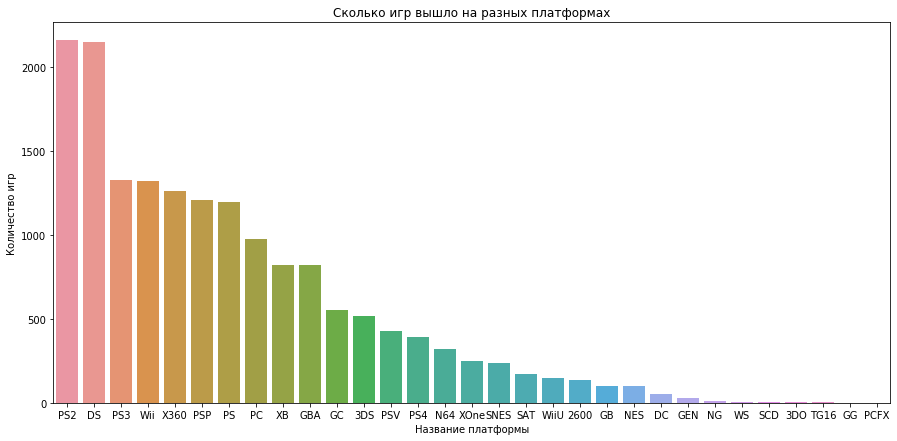

In [11]:
# Посмотрим, на каких платформах больше всего выходило игр

plt.figure(figsize=(15,7))
sns.countplot(x='platform', data=games, order = games['platform'].value_counts().index)

plt.title('Сколько игр вышло на разных платформах')
plt.xlabel('Название платформы')
plt.ylabel('Количество игр');

In [12]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: float64(7), object(4)
memory usage: 1.4+ MB


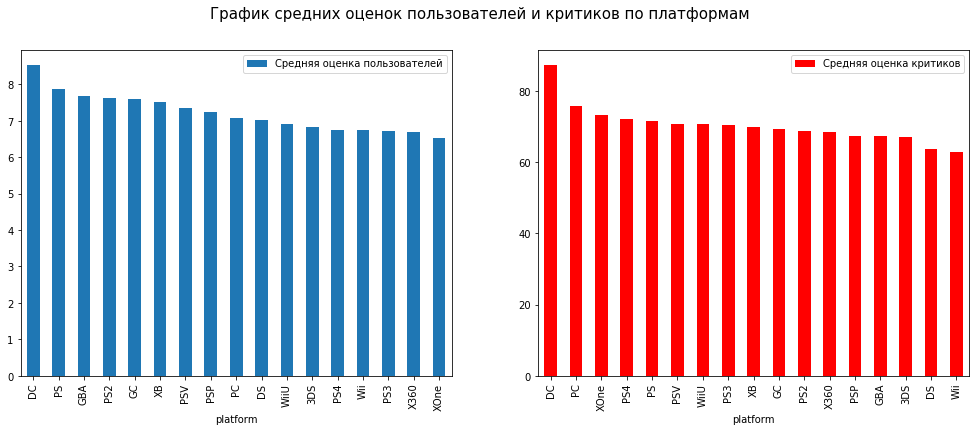

In [13]:
#Посмотрим, игры каких платформы критики и пользователи оценивают лучше всего

fig, ax =plt.subplots(1,2)

(games
 .pivot_table(index='platform', values='user_score')
 .sort_values(by='user_score', ascending=False)
 .plot(y='user_score', kind='bar', figsize=(17,6), label='Средняя оценка пользователей', ax=ax[0])
)


(games
 .pivot_table(index='platform', values='critic_score')
 .sort_values(by='critic_score', ascending=False)
 .plot(y='critic_score', kind='bar', color='red', label='Средняя оценка критиков', ax=ax[1])
)

fig.show()
fig.suptitle('График средних оценок пользователей и критиков по платформам', fontsize = 15);

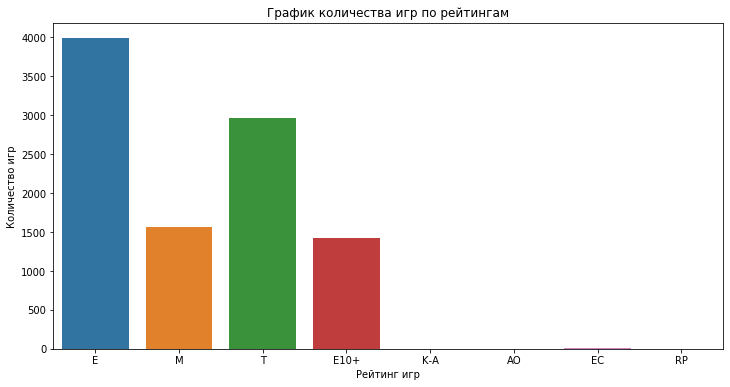

In [14]:
# Посмотрим, игры каких рейтингов встречаются чаще
plt.figure(figsize=(12,6))
sns.countplot(games['rating'])

plt.title('График количества игр по рейтингам')
plt.xlabel('Рейтинг игр')
plt.ylabel('Количество игр');

In [15]:
# Для удобства восприятия составим словарь рейтингов, где пропишем их минимальный возраст
# В колонке рейтинга встречался рейтинг RP - это значит, что он еще не был определен на момент формирования датасета. Заменим его NaN

age_raiting = {'EC': '3', 'E': '6', 'E10+': '10', 'T': '13', 'M': '17', 'AO': '18', 'K-A': '6', 'RP': np.nan}

### Вывод

При первичном анализе были замечены следующие закономерности:
- Больше всего игр было выпущено для PS2 и DS
- Игры на платформе DS и пользователи, и критики оценивают выше остальных
- Больше всего в выборке игр с рейтингом E (Everyone, для детей старше 6 лет)

## Обработка пропусков <a name="empty"></a>

### Количество пропущенных значений

In [16]:
#Посчитаем количество пустых значений
games.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating             6766
dtype: int64

**Удалять пропущенные значения в колонках `critic_score`, `user_score`, `rating` считаю нецелесобразным, потому что удалится половина данных, что очень критично**

### Заполнение и удаление пропусков

In [17]:
#Посмотрим подробнее на игры, у которых пропущены названия и жанр
games[games['name'].isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Удалим эти две строки

In [18]:
#Посмотрим подробнее на игры с пропущенным годом выпуска
games[games['year_of_release'].isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,NaN,E10+
16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


У 269 игр пропущен год выпуска, можно попробовать восстановить пропущенные значения через парсинг. Но так как пропущенных значений всего 1,6%, можно их удалить

In [19]:
#Напишем парсер, который будет вводить в поисковую выдачу google название игры и "year of release", а собирать год выпуска

# #!pip install beautifulsoup4
# import requests
# import re
# from bs4 import BeautifulSoup

# #Выделим названия игр, у которых пропущен год выпуска
# empty_year = games[games['year_of_release'].isnull()]['name']

# #запишем все комбинации поискового запроса и "название игры+год выпуска" в список urls
# urls = []
# for name in empty_year:
#     url = 'http://www.google.com/search?q='+name+' year of release'
#     urls.append(url)
    
    
    
# years = {}
# for url in urls:
#     user_agent = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.47 Safari/537.36'
#     headers = {'User-Agent': user_agent}

#     response = requests.get(url, headers=headers, allow_redirects=True)
#     page_bs = BeautifulSoup(response.text)
    
#     try:
#         year_container = page_bs.find('div', {'class': 'Z0LcW XcVN5d'})
#         year = re.sub(r'[^А-Яа-я0-9 ]', '', year_container.text)
#         years[url] = year
#         time.sleep(15)
#     except:
#         continue 
        
# print('В результате парсинга поисковой выдачи было восстановлено', len(years), 'пропущенных значений')

In [20]:
games.dropna(subset = ['name','year_of_release'], inplace = True)

In [21]:
# Сбросим индекс после удаления
games = games.reset_index()

In [22]:
# Приведем колонку года к типу int
games['year_of_release'] = games['year_of_release'].astype(int)

In [23]:
print('Пропущено', games['critic_score'].isna().sum(), 'оценок критиков')
print('Пропущено', games['user_score'].isna().sum(), 'оценок пользователей')

Пропущено 8461 оценок критиков
Пропущено 8981 оценок пользователей


40-50% данных пропущено. Хочется отметить, что заполнять эти данные средним значением считаю нецелесообразным, ведь оценки -- очень субъективное значение. Нельзя ориентироваться, например, на жанр игры, платформу или денежные сборы, ведь это как с кино -- абсолютно не значит, что действительно стоящая игра принесет много денег, или что все игры на PS пользуются большим успехом, чем игры Х360. Поэтому оставим пропуски

In [24]:
#Посмотрим подробнее на игры с пропущенным рейтингом
games[games['rating'].isnull()]

,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,10,Nintendogs,DS,2005,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
16439,16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16440,16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16441,16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16442,16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


*40% всего датасета содержат пропуск вместо рейтинга. Хотя ранее было отмечено, что больше всего в выборке игр рейтингом Е (для всех) и T (подростки), заполнять пропущенные значения самым часто встречающимся значением не будем. Ведь мы рискуем исказить почти половину данных, поэтому пропуски в колонке `rating` также оставим*

### Вывод

При первичном анализе были обнаружены пропуски в колонках `name`, `year_of_release`, `critic_score`, `user_score`, `rating`. Скорее всего, они были пропущенны в результате загрузки с информационнного сайта (не на всех сайтах одновременно указаны все перечисленные характеристики) 

Игры с пропущенным названием и жанром были удалены (их всего 2 шт.)

Восполнить пробелы в оценках пользователей и критиков, рейтингах и годе выпуска можно методом парсинга с разных сайтов, но это довольно времязатратно. Заполнить оценки средним значением, а рейтинг - модой не представляется уместным, ведь так мы рискуем заполнить почти половину всего датасета нереалистичными значениями. Поэтому было решено оставить пропуски

## Подсчет суммарных продаж <a name="sold"></a>

In [25]:
# Создадим новую колонку, где суммируем миллионы проданных копий
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

# Исследовательский анализ данных 

## Анализ игр по годам <a name="sold_year"></a>

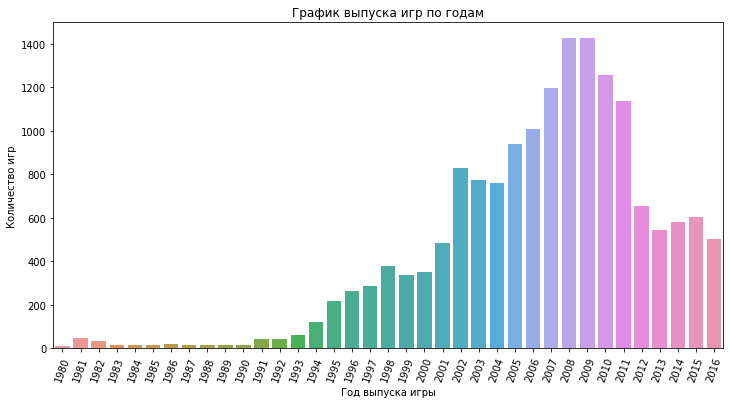

In [26]:
# Посмотрим, сколько игр выпускалось в разные годы
plt.figure(figsize=(12,6))

sns.countplot(games['year_of_release'])
plt.title('График выпуска игр по годам')
plt.xlabel('Год выпуска игры')
plt.xticks(rotation=70)
plt.ylabel('Количество игр');

Видим, что игры начали активно выпускать с 1995 года. Отбросим данные до 1995 года

In [27]:
games = games.query('year_of_release >= 1995')

### Вывод
Активно выпускать игры начали в 1995 году. Основной пик выпуска приходится на 2005 - 2011 года, потом идет спад до уровня 2001 года

## Анализ игровых платформ <a name="top_platform"></a>

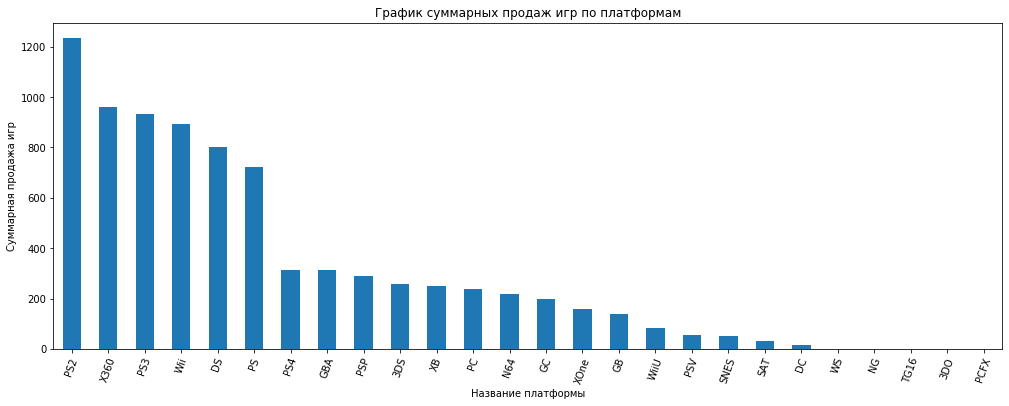

In [28]:
# Выделим платформы с самыми большими суммарными продажами 
(games
 .pivot_table(index='platform', values='total_sales', aggfunc='sum')
 .sort_values(by='total_sales', ascending=False)
 .plot(y='total_sales', kind='bar', figsize=(17,6), legend=False)
)
plt.title('График суммарных продаж игр по платформам')
plt.xlabel('Название платформы')
plt.xticks(rotation=70)
plt.ylabel('Суммарная продажа игр');

Можем выделить ТОП-6 платформ с наибольшим числом продаж: PS2, X360, PS3, Wii, DS и PS. Построим для них график распределения продаж по годам

In [29]:
top6_platform = ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']

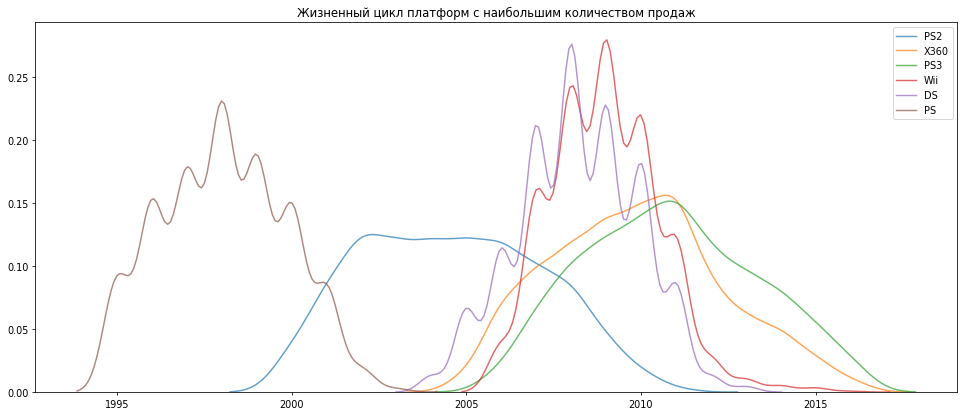

In [30]:
plt.figure(figsize=(17,7), dpi= 70)

for platform in top6_platform:
    sns.kdeplot(games.loc[games['platform'] == platform, 'year_of_release'], label=platform, alpha=0.7)
    
plt.title('Жизненный цикл платформ с наибольшим количеством продаж');   

- Видим, что средний срок, за который появляются новые и исчезают старые платформы, - 5-10 лет. 

- PS была популярна до 2000 года, ей на смену пришла PS2, которая с выходом PS3 уступила новой версии и стала терять популярность. 

- Nintendo DS и Wii были одинаково популярны в 2005-2010 годах, но их популярность спала в 2012 году, тогда же набрали популярность PS3 и X360, которые были популярными вплоть до 2016 года. 

Так-как выход новой платформы знаменует упадок предыдущей версии, выделим актуальный период и в дальнейшем будем анализировать его. 
Чтобы узнать, какой год стал началом нового цикла, посмотрим, как распределяются жизненные циклы разных версий платформы PS

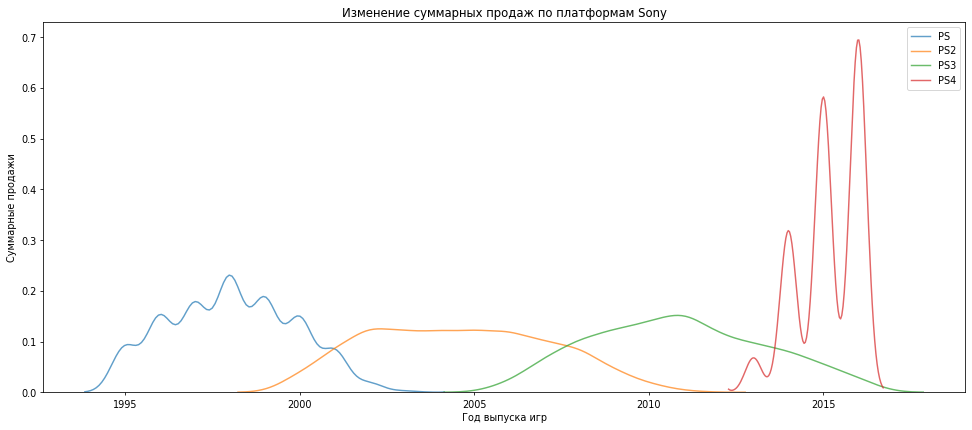

In [31]:
sony = ['PS', 'PS2', 'PS3', 'PS4']
plt.figure(figsize=(17,7), dpi= 70)

for platform in sony:
    sns.kdeplot(games.loc[games['platform'] == platform, 'year_of_release'], label=platform, alpha=0.7)
    
plt.title('Изменение суммарных продаж по платформам Sony')
plt.xlabel('Год выпуска игр')
plt.ylabel('Суммарные продажи');

На графике видно, что спад популярности PS3 приходится на 2012 год. А уже в 2013 начинает набирать популярность PS4. Делаем вывод, что это и есть период актуальных платформ. Выделим его и в дальнейшем будем анализировать именно актуальный период

In [32]:
actual_period = games.query('year_of_release >= 2013')

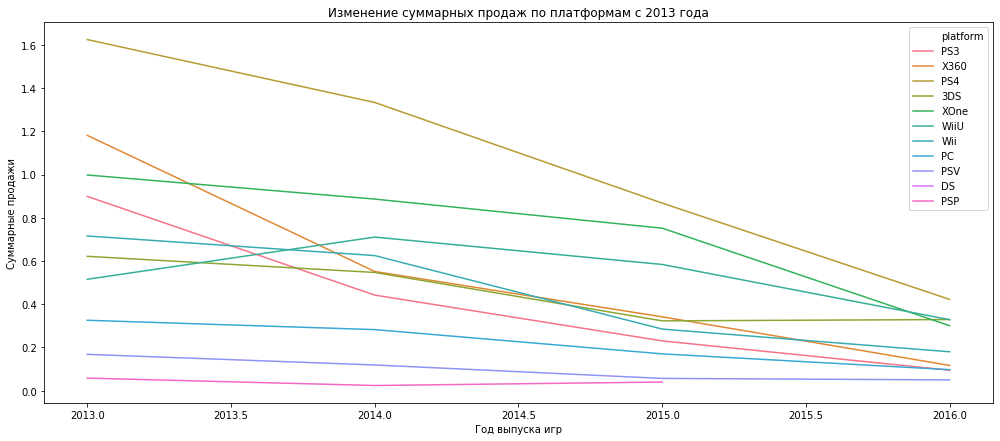

In [33]:
# Учитывая средний срок жизни платформ, посмотрим, какие из них (помимо PS4) набирают популярность с 2013 года

plt.figure(figsize=(17,7))
sns.lineplot(data=actual_period, x='year_of_release', y='total_sales', hue='platform', ci=None)
    
plt.title('Изменение суммарных продаж по платформам с 2013 года')
plt.xlabel('Год выпуска игр')
plt.ylabel('Суммарные продажи');   

Видим, что только 4 платформы (PS4, XOne, WiiU и 3DS) в актуальном периоде не теряют популярность.

In [34]:
# Выделим актуальные платформы
actual_platform = ['PS4', 'XOne', 'WiiU', '3DS']
actual_games = actual_period.query('platform in @actual_platform')

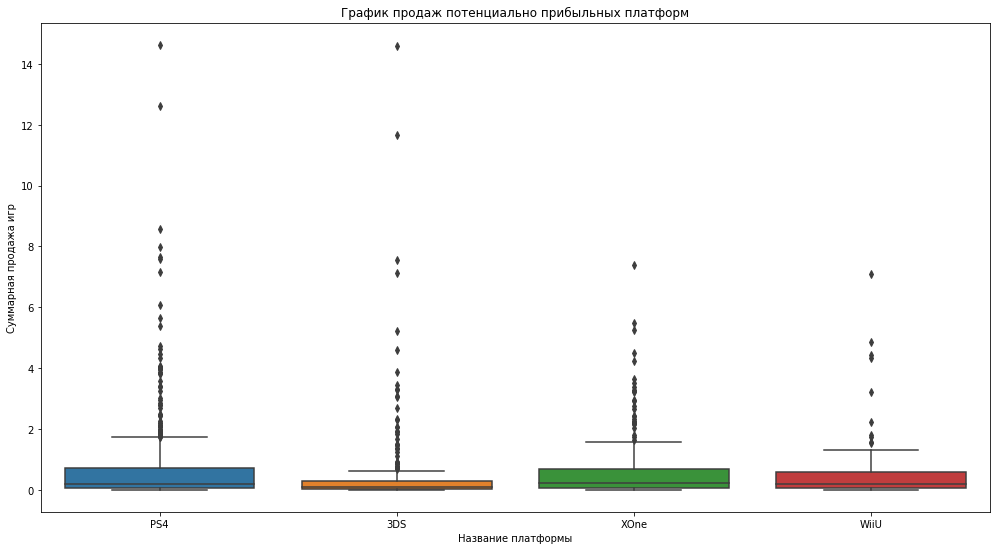

In [35]:
# Построим «ящик с усами» по глобальным продажам игр в разбивке по потенциально прибыльным платформам
plt.figure(figsize=(17,9))
ax = sns.boxplot(x='platform', y='total_sales', data=actual_games)

plt.title('График продаж потенциально прибыльных платформ')
plt.xlabel('Название платформы')
plt.ylabel('Суммарная продажа игр');

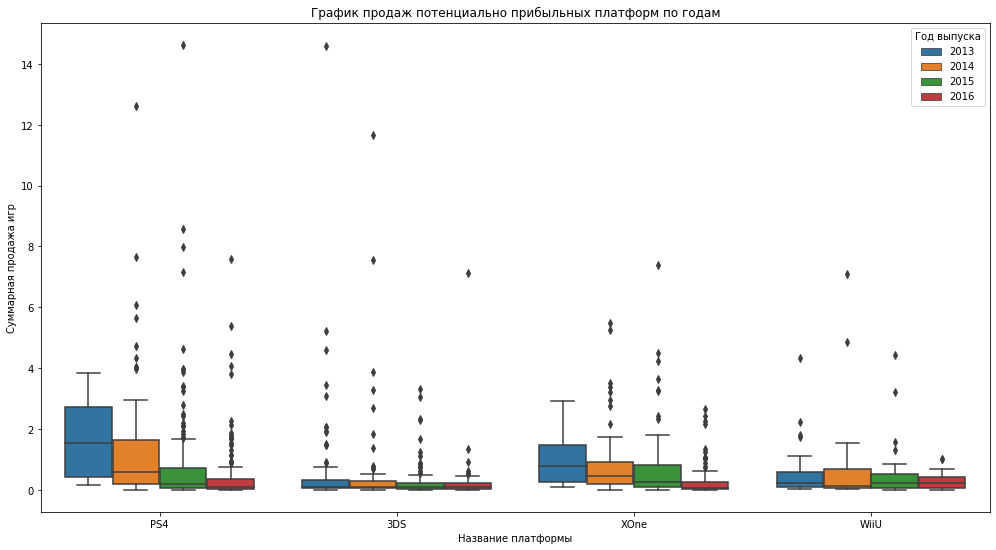

In [36]:
# Оценим распределение продаж по годам для каждой платформы
plt.figure(figsize=(17,9))
ax = sns.boxplot(x='platform', y='total_sales', hue='year_of_release', data=actual_games)

plt.title('График продаж потенциально прибыльных платформ по годам')
plt.xlabel('Название платформы')
plt.ylabel('Суммарная продажа игр')
plt.legend(title='Год выпуска');

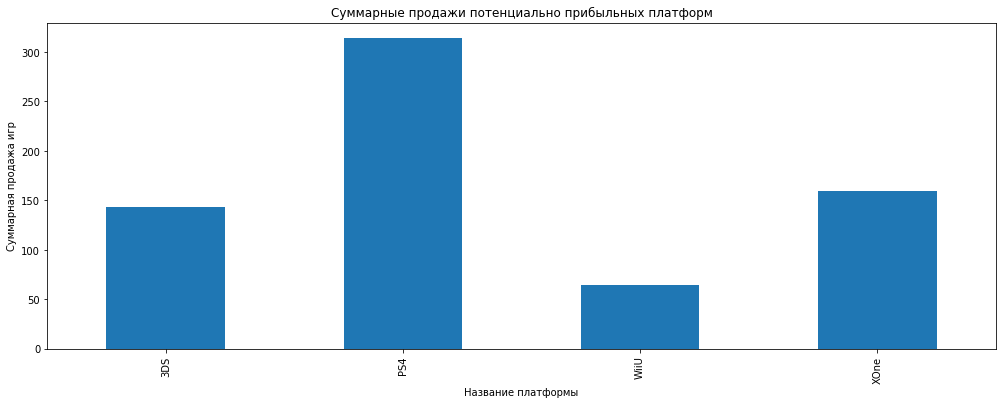

In [37]:
# Посмотрим на кол-во проданных игр по платформам за актуальный период
(actual_games
 .pivot_table(index='platform', values='total_sales', aggfunc='sum')
 .plot(y='total_sales', kind='bar', figsize=(17,6), legend=False)
)
plt.title('Суммарные продажи потенциально прибыльных платформ')
plt.xlabel('Название платформы')
plt.ylabel('Суммарная продажа игр'); 

Проанализировав 3 графика распределения продаж платформ, которые в актуальном периоде начинали набирать популярность, можно сделать вывод, что самые прибыльные платформы - PS4 и XOne. По количеству проданных игр платформы Nintendo, приставка 3DS значительно опережает WiiU, поэтому 3DS также можно считать потенциально прибыльной. Выделим их в отдельную группу


In [38]:
potencial_platform = ['PS4', 'XOne', '3DS']
potencial_games = actual_period.query('platform in @potencial_platform')

### Вывод
- В ТОП-6 платформ с наибольшим числом продаж за все время вошли: PS2, X360, PS3, Wii, DS и PS

- Средний срок, за который появляются новые и исчезают старые платформы, - 5-10 лет

- Актуальный период для анализа потенциально прибыльных платформ - с 2013 года

- Потенциально прибыльные платформы: PS4, XOne и 3DS

In [39]:
# import plotly.express as px

# fig = px.line(games.query('year_of_release > 2013').pivot_table(index = ['year_of_release', 'platform'], values = 'total_sales', aggfunc = 'sum').reset_index(),
#              x = 'year_of_release', y = 'total_sales', color = 'platform', title = 'Изменение суммарных продаж по платформам с 2014')
# fig.show()

In [40]:
# sony = ['PS', 'PS2', 'PS3', 'PS4']

# fig = px.line(games.query('platform in @sony').pivot_table(index = ['year_of_release', 'platform'], values = 'total_sales', aggfunc = 'sum').reset_index(),
#              x = 'year_of_release', y = 'total_sales', color = 'platform', title = 'Изменение суммарных продаж по платформам Sony')
# fig.show()

### Вывод
- В ТОП-6 платформ с наибольшим числом продаж вошли: PS2, X360, PS3, Wii, DS и PS

- Средний срок, за который появляются новые и исчезают старые платформы, - 5-10 лет

- Nintendo DS и Wii были одинаково популярны в 2005-2010 годах, но их популярность спала в 2012 году, тогда же набрали популярность PS3 и X360, которые остаются актуальными вплоть до 2016 года

- Средние суммарные продажи игр на Х360 немного превышают PS3, но не во всех странах. В Северной Америке популярность X360 практически в два раза больше PS3. А вот в Японии предпочитают PS3. На графике видно, что суммарные продажи Х360 больше PS3. 

## Как отзывы пользователей и критиков влияют на продажи <a name="score"></a>

In [41]:
# Посмотрим корреляцию потенциальных платформ с оценками критиков и пользователей
display(games.query('platform in @potencial_platform').pivot_table(index = 'platform', values = ['critic_score', 'user_score', 'total_sales'], aggfunc = 'corr'))

critic_score  total_sales  user_score
platform                                                    
3DS      critic_score      1.000000     0.348740    0.745222
         user_score        0.745222     0.222078    1.000000
         total_sales       0.348740     1.000000    0.222078
PS4      critic_score      1.000000     0.406568    0.557654
         user_score        0.557654    -0.031957    1.000000
         total_sales       0.406568     1.000000   -0.031957
XOne     critic_score      1.000000     0.416998    0.472462
         user_score        0.472462    -0.068925    1.000000
         total_sales       0.416998     1.000000   -0.068925

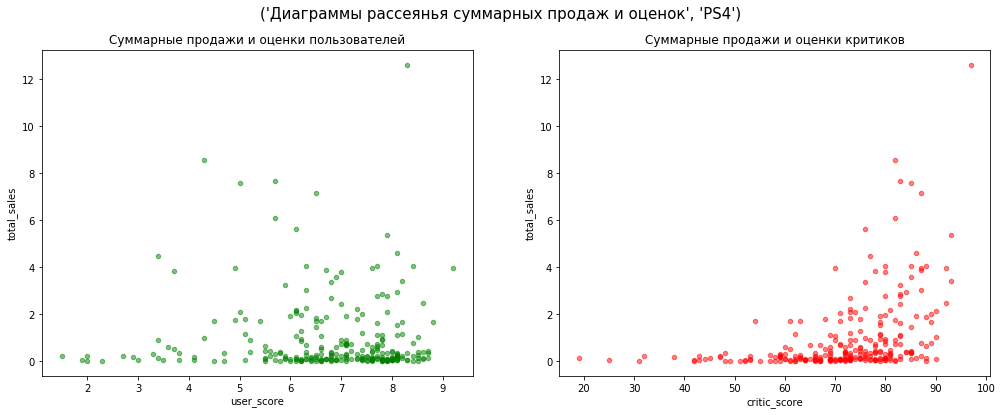

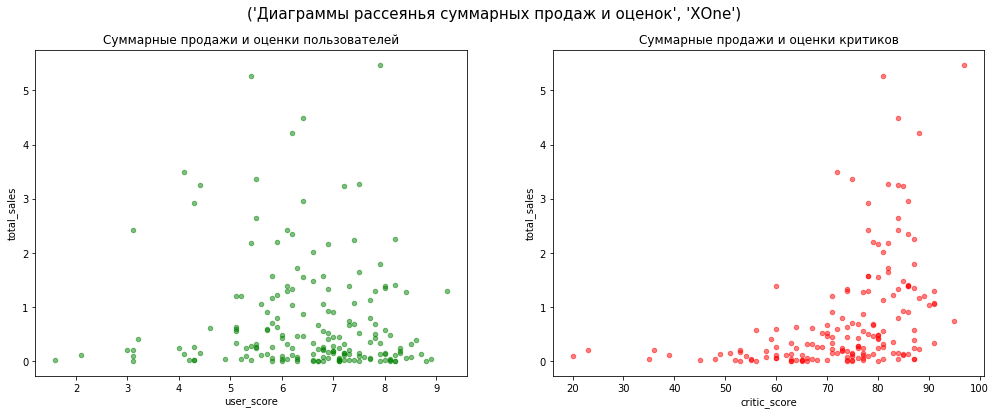

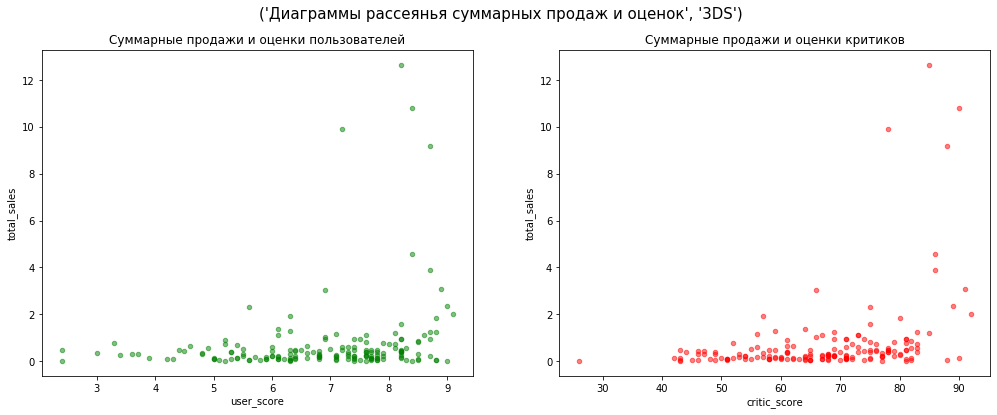

In [42]:
# Построим графики рассеянья для каждой потенциально прибыльной платформы

for platform in potencial_platform:
    platform_data = games[games['platform'] == platform]
    
    fig, ax = plt.subplots(1,2)
    platform_data.plot(x='user_score', y='total_sales', kind='scatter', figsize=(17, 6), alpha=0.5, color='g', ax=ax[0], title='Суммарные продажи и оценки пользователей')
    platform_data.plot(x='critic_score', y='total_sales', kind='scatter', alpha=0.5, color='r', ax=ax[1], title='Суммарные продажи и оценки критиков')
    fig.suptitle(('Диаграммы рассеянья суммарных продаж и оценок', platform), fontsize = 15);

In [43]:
# Посмотрим, как коррелируют с оценками продажи игр на других платформах
other_platform = games.query('platform != ["PS4", "XOne", "3DS"]')

print('Корреляция суммарных продаж других платформ с оценками:')
print('Пользователей -- ', other_platform.corr().loc['user_score','total_sales'])
print('Критиков -- ', other_platform.corr().loc['critic_score','total_sales'])

Корреляция суммарных продаж других платформ с оценками:
Пользователей --  0.09253102209623479
Критиков --  0.23677038029492706


### Вывод

- На продажи платформы 3DS оценки критиков влияют значительнее, чем оценки пользователей, но и пользовательские имеют вес
- На продажи PS4 и XOne влияют только оценки критиков, корреляция продаж с оценками пользователей отрицательная
- На продажи игр других платформ оценки влияют практически также, как и на продажи 3DS

In [70]:
# display(games.query('platform in @sony').pivot_table(index = 'platform', values = ['critic_score', 'user_score', 'total_sales'], aggfunc = 'corr'))

## Самые прибыльные жанры игр <a name="genre"></a>

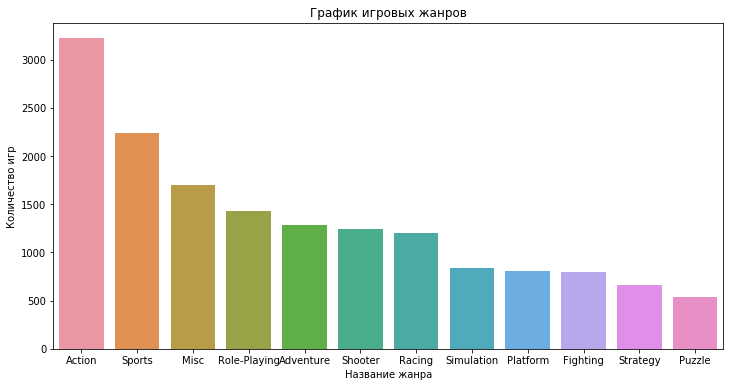

In [45]:
#Посмотрим, игры каких жанров чаще всего встречаются в выборке

plt.figure(figsize=(12,6))
sns.countplot(x='genre', data=games, order = games['genre'].value_counts().index)

plt.title('График игровых жанров')
plt.xlabel('Название жанра')
plt.ylabel('Количество игр');

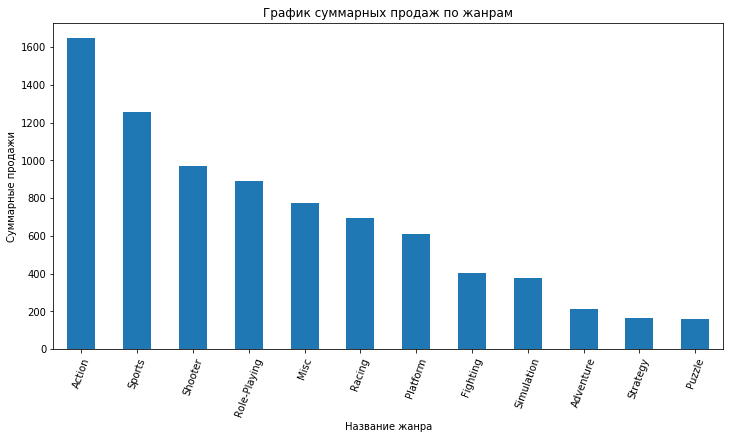

In [46]:
(games
 .pivot_table(index='genre', values='total_sales', aggfunc='sum')
 .sort_values(by='total_sales', ascending=False)
 .plot(y='total_sales', kind='bar', figsize=(12,6), legend=False)
)

plt.title('График суммарных продаж по жанрам')
plt.xlabel('Название жанра')
plt.xticks(rotation=70)
plt.ylabel('Суммарные продажи');

Shooter входит в тройку самых продаваемых, хотя по количеству игр в этом жанре он находится на 6 месте. Посмотрим, в каком году shooter стал популярным у пользователей

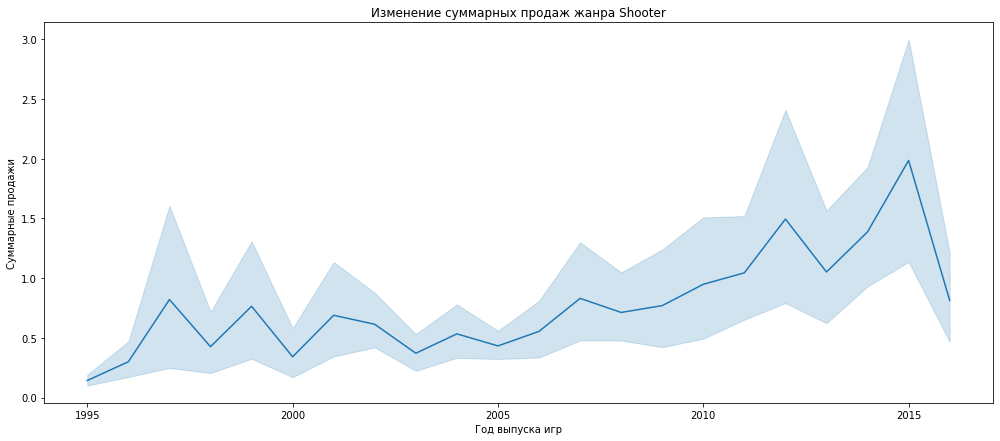

In [47]:
plt.figure(figsize=(17,7))
sns.lineplot(data=games.query('genre == "Shooter"'), x='year_of_release', y='total_sales')
    
plt.title('Изменение суммарных продаж жанра Shooter')
plt.xlabel('Год выпуска игр')
plt.ylabel('Суммарные продажи');

In [48]:
# Посмотрим, какие игры с 2011 года сделали shooter столь популярным
(games[(games['genre']=='Shooter') & (games['year_of_release'] >= 2011)]).head(5)

,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
29,29,Call of Duty: Modern Warfare 3,X360,2011,Shooter,9.04,4.24,0.13,1.32,88.0,3.4,M,14.73
31,31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
34,34,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79
35,35,Call of Duty: Black Ops II,X360,2012,Shooter,8.25,4.24,0.07,1.12,83.0,4.8,M,13.68
37,37,Call of Duty: Modern Warfare 3,PS3,2011,Shooter,5.54,5.73,0.49,1.57,88.0,3.2,M,13.33


### Вывод
- Игры жанра Action и Sports -- самые популярные и принесли больше всего продаж, можно сказать, что они самые прибыльные
- В 2011 году была выпущена серия игр Call of Duty, которые принесли жанру Shooter третью строку среди самых популярных игр
- Игры Puzzle и Strategy -- самые редкопродаваемые

# Собирательный образ пользователей по регионам

## Северная Америка <a name="na"></a>

In [49]:
# Напишем функцию для упрощения построения графиков

def someplot(index, region):
    (actual_period
     .pivot_table(index=index, values=region, aggfunc='sum')
     .sort_values(by=region, ascending=False)
     .plot(y=region, kind='bar', figsize=(12,6), legend=False)
    )

In [71]:
# Напишем функцию для построения круговых диаграмм для рейтингов

def somepieplot(index, region):
    (actual_period
     .pivot_table(index=index, values=region, aggfunc='sum')
     .sort_values(by=region, ascending=False)
     .plot(y=region, kind='pie', figsize=(15,6), legend=False)
    )
    plt.ylabel('Рейтинг ESRB')

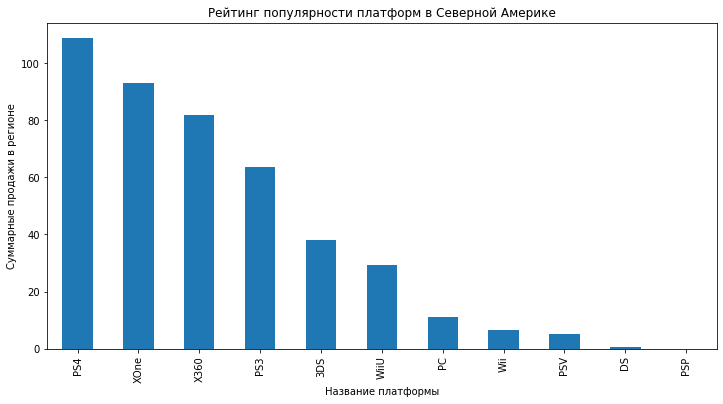

In [51]:
# Найдем Топ-5 самых популярных платформ 
someplot('platform', 'na_sales')

plt.title('Рейтинг популярности платформ в Северной Америке')
plt.xlabel('Название платформы')
plt.ylabel('Суммарные продажи в регионе');

В Северной Америке самые популярные платформы: PS4, XOne, X360, PS3 и 3DS.

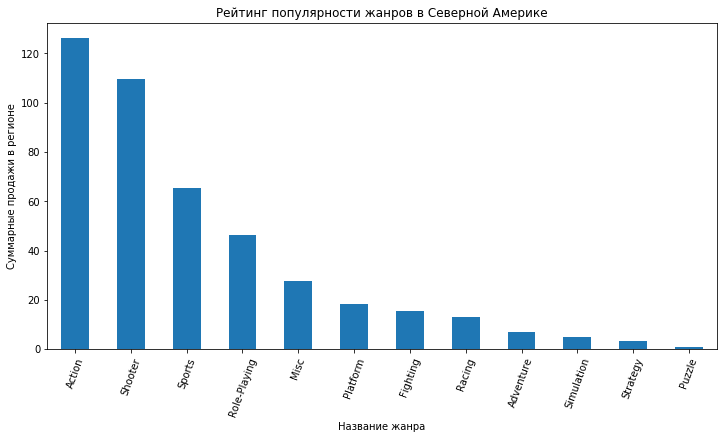

In [52]:
# Найдем Топ-5 самых популярных жанров
someplot('genre', 'na_sales')

plt.title('Рейтинг популярности жанров в Северной Америке')
plt.xlabel('Название жанра')
plt.xticks(rotation=70)
plt.ylabel('Суммарные продажи в регионе');

Топ-3 игровых жанров не отличается от мировых - это Action, Shooter и Sports. В Северной Америке также популярны жанры Role-Playing и Misc

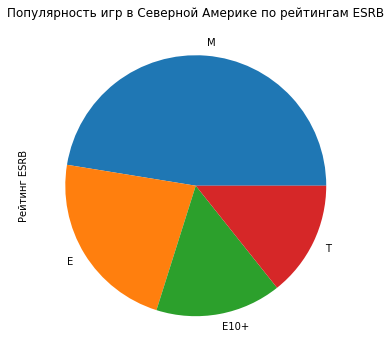

In [53]:
# Посмотрим, влияет ли рейтинг ESRB на продажи
somepieplot('rating', 'na_sales')

plt.title('Популярность игр в Северной Америке по рейтингам ESRB');

На графике видно, что игры с рейтингом M (17+) пользуются популярностью больше, чем игры для всех возрастов и подростков. 

### Вывод
- В Северной Америке пользователи предпочитают PS4 другим платформам. В Топ-5 также входят XOne, X360, PS3 и 3DS
- Топ-5 игровых жанров практически не отличается от мировых - это Action, Shooter, Sports, Role-Playing и Misc. Но shooter популярнее sport
- Рейтинг ESRB влияет на продажи, так игры с рейтингом M популярнее игр для подростков (T) и  для всех (Е)

## Европа <a name="eu"></a>

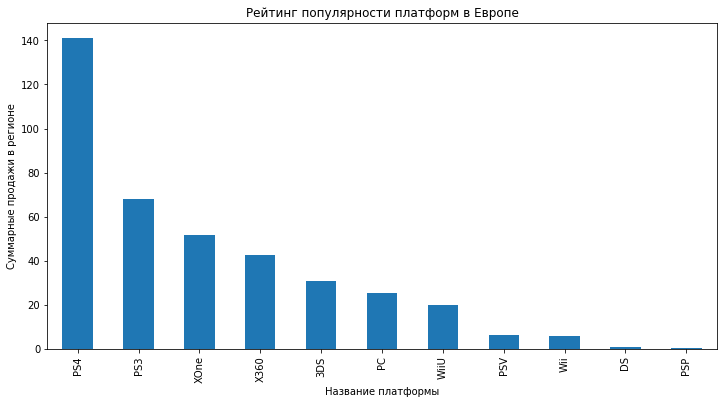

In [54]:
# Найдем Топ-5 самых популярных платформ
someplot('platform', 'eu_sales')

plt.title('Рейтинг популярности платформ в Европе')
plt.xlabel('Название платформы')
plt.ylabel('Суммарные продажи в регионе');

В Европе пользователи предпочитают PS4 и PS3, XOne и X360 значительно уступают Sony по популярности. Замыкает пятерку лидеров платформа 3DS

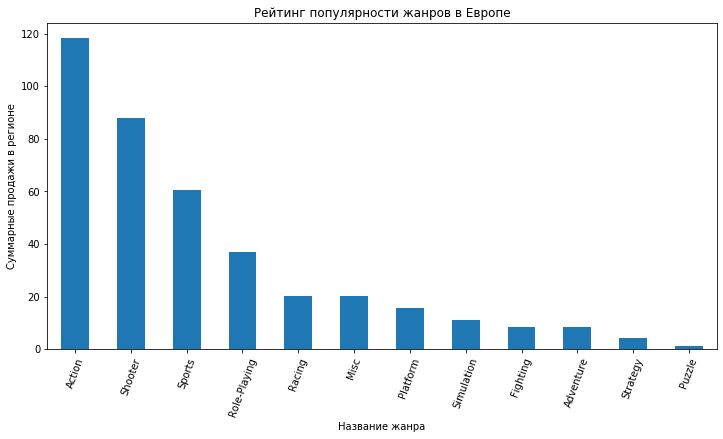

In [55]:
# Найдем Топ-5 самых популярных жанров
someplot('genre', 'eu_sales')

plt.title('Рейтинг популярности жанров в Европе')
plt.xlabel('Название жанра')
plt.xticks(rotation=70)
plt.ylabel('Суммарные продажи в регионе');

Топ-3 игровых жанров не отличается от Северной Америки - это Action, Shooter и Sports. Однако в Европе игры жанра Racing популярнее Misc

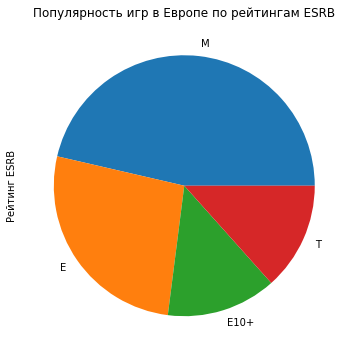

In [56]:
# Посмотрим, влияет ли рейтинг ESRB на продажи
somepieplot('rating', 'eu_sales')

plt.title('Популярность игр в Европе по рейтингам ESRB');

Игры с рейтингом M (17+) также опережают игры для всех и подростков

### Вывод
- В Европе пользователи предпочитают PS4. Предыдущая версия Sony (PS3) пользуется большей популярностью, чем новая приставка XOne.
- Топ-3 игровых жанров: Action, Shooter и Sports. Однако в Европе Racing немного популярнее Misc
- Игры с рейтингом M (17+) также опережают игры для всех и подростков

## Япония <a name="jp"></a>


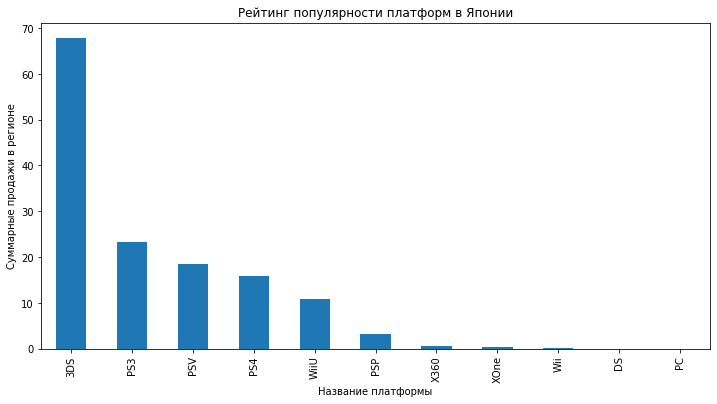

In [57]:
# Найдем Топ-5 самых популярных платформ
someplot('platform', 'jp_sales')

plt.title('Рейтинг популярности платформ в Японии')
plt.xlabel('Название платформы')
plt.ylabel('Суммарные продажи в регионе');

В Японии рейтинг популярных платформ отличается от Северной Америки, Европы и мира в целом. Пользователи предпочитают 3DS. Следом идут PS3, PSV, PS4 и WiiU

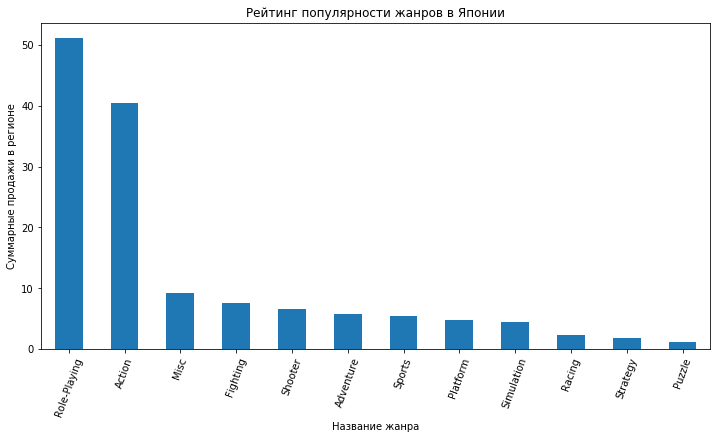

In [58]:
# Найдем Топ-5 самых популярных жанров
someplot('genre', 'jp_sales')

plt.title('Рейтинг популярности жанров в Японии')
plt.xlabel('Название жанра')
plt.xticks(rotation=70)
plt.ylabel('Суммарные продажи в регионе');

Рейтинг жанров также отличается, так на первом месте находятся игры Role-Playing. Action, который во всем мире находится на первом месте, на 2 строчке. Следом идут Misc, Fighting и Shooter. Sports, который во всем мире находится на 2 месте в мире, в Японии только на 7 месте

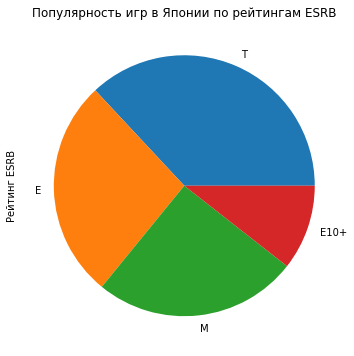

In [59]:
# Посмотрим, влияет ли рейтинг ESRB на продажи
somepieplot('rating', 'jp_sales')

plt.title('Популярность игр в Японии по рейтингам ESRB');

Игры для подростков (Т) на первом месте. Затем игры для всех (Е), примерно на этом же уровне популярности находятся игры с рейтингом М 

### Вывод
- Предпочтения пользователей из Японии значительно отличаются от вкусов пользователей со всего мира и Северной Америки и Европы в частности
- Так пользователи предпочитают 3DS. Следом идут приставки Sony (PS3, PSV, PS4) и WiiU. Приставки XOne и X360 не популярны.
- На первом месте находятся игры жанра Role-Playing. Следом идут Action, Misc, Fighting и Shooter. А вот Sports, который во всем мире находится на 2 месте в мире, в Японии только на 7 месте
- Игры для подростков (Т) популярнее игр для всех (Е) и М

## Выводы по разделу

Проанализировав игоровые предпочтения пользователей из трех регионов: Северной Америки, Европы и Японии, можно сделать вывод, что вкусы отличаются. Это нужно учитывать при закупках игр для каждого региона. 

- В Топ-5 платформ для всех регионов входят: PS4 (лидер в Северной Америке и Европе), 3DS (лидер в Японии). XOne и X360 также входят в топ-5 платформ Европы и Северной Америки.

- Жанровые вкусы в Европе и Северной Америке схожи. Наибольшей популярностью пользуются Action, Shooter и Sports. Наименьшей - Puzzle и Strategy. На первом месте в Японии находятся игры Role-Playing, затем Action и Misc. А вот популярные во всем мире Sports в Японии не пользуются спросом

- В Северной Америке и Европе игры с рейтингом М (17+) популярнее всего. В Японии - Т (13+). Затем идут игры для всех (Е)

In [60]:
# jp_pltf_pivot = games.query('year_of_release > 2013').pivot_table(index = 'platform', aggfunc = 'sum', values = 'jp_sales').reset_index().sort_values('jp_sales', ascending = False).head(5)
# display(jp_pltf_pivot)

# # визуализируем с помощью круговой диаграммы

# import plotly.graph_objects as go

# fig = go.Figure(data=[go.Pie(labels=jp_pltf_pivot.platform, values=jp_pltf_pivot.jp_sales)])
# fig.show()

# # посмотрим на жанры

# jp_genres_pivot = games.query('year_of_release > 2013').pivot_table(index = 'genre', aggfunc = 'sum', values = 'jp_sales').reset_index().sort_values('jp_sales', ascending = False).head(5)
# display(jp_genres_pivot)

# # визуализируем

# fig = px.bar(jp_genres_pivot, x = 'genre', y = 'jp_sales', color = 'jp_sales', title = 'Распределение по жанрам Япония')
# fig.show()

# # рейтинг

# fig = px.line(games.query('year_of_release > 2013').pivot_table(index = 'rating', values = 'jp_sales', aggfunc = 'sum').reset_index(),
#              x = 'rating', y = 'jp_sales')
# fig.show()

# Проверка гипотез

## Средние пользовательские рейтинги платформ Xbox One и PC одинаковые <a name="x_p"></a>

In [61]:
# Выделим XOne и PC в отдельные группы и уберем пропуски в рейтингах пользователей
XOne_games = actual_period[(~(actual_period['user_score'].isnull())) & (actual_period['platform'] == 'XOne')]
XOne_users = XOne_games['user_score']

In [62]:
PC_games = actual_period[(~(actual_period['user_score'].isnull())) & (actual_period['platform'] == 'PC')]
PC_users = PC_games['user_score']

**Нулевая гипотеза:** средний рейтинг пользователей платформ XOne и PC одинаковый

**Альтернативная гипотеза:** средние пользовательские рейтинги XOne и PC разные

Так как у нас в распоряжении лишь часть генеральной совокупности, сделаем статистический тест, применив метод scipy.stats.ttest_ind. Но сначала проверим равенство дисперсий (параметр ddof=1 так как имеем дело с выборкой, а не генеральной совокупностью).

In [64]:
print('Дисперсия пользовательских оценок XOne:', XOne_users.var(ddof=1))
print('Дисперсия пользовательских оценок PC:', PC_users.var(ddof=1))

Дисперсия пользовательских оценок XOne: 1.9069968429360702
Дисперсия пользовательских оценок PC: 3.035892752408884


Дисперсии отличаются, поэтому параметр **equal_var = False**

In [65]:
alpha = .05

results = st.ttest_ind(XOne_users, PC_users, equal_var = False)

print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу, значит, средние оценки отличаются')
else:
    print('Не получилось отвергнуть нулевую гипотезу, значит, средние оценки пользователей равны')

p-значение: 0.14759594013430463
Не получилось отвергнуть нулевую гипотезу, значит, средние оценки пользователей равны


### Вывод: 
В результате статистического теста мы пришли к выводу, что средние оценки пользователей PC и XOne действительно равны. Но значение p-value указывает на то, что с вероятность 14% равенство может получиться случайным.


## Средние пользовательские рейтинги жанров Action и Sports разные <a name="a_s"></a>

In [66]:
# Выделим жанры в отдельные переменные 
games_action = actual_period[(~(actual_period['user_score'].isnull())) & (actual_period['genre'] == 'Action')]
action_users = games_action['user_score']

In [67]:
games_sports = actual_period[(~(actual_period['user_score'].isnull())) & (actual_period['genre'] == 'Sports')]
sports_users = games_sports['user_score']

**Нулевая гипотеза:** средние пользовательские рейтинги жанров Action и Sports одинаковые

**Альтернативная гипотеза:** средние пользовательские рейтинги жанров Action и Sports разные

In [68]:
# Проверим равенство дисперсий
print('Дисперсия пользовательских оценок Action:', action_users.var(ddof=1))
print('Дисперсия пользовательских оценок Sports:', sports_users.var(ddof=1))

Дисперсия пользовательских оценок Action: 1.76936090424827
Дисперсия пользовательских оценок Sports: 3.1806128144654062


Дисперсии отличаются, поэтому при проверке гипотез будем использовать статистический метод scipy.stats.ttest_ind с параметром equal_var = False

In [69]:
alpha = .05

results = st.ttest_ind(action_users, sports_users, equal_var = False)

print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу, значит, средние оценки отличаются')
else:
    print('Не получилось отвергнуть нулевую гипотезу, значит, средние оценки пользователей равны')

p-значение: 1.4460039700704315e-20
Отвергаем нулевую гипотезу, значит, средние оценки отличаются


### Вывод
В результате статистического теста мы отвергли нулевую гипотезу и можем сделать вывод, что средние рейтинги пользователей жанров Action и Sports действительно отличаются

# Анализ игр: итоги <a name="end"></a>

В результате анализа данных были замечены следующие закономерности:
- Больше всего игр было выпущено для PS2 и DS
- Активно выпускать игры начали в 1995 году. Основной пик выпуска приходится на 2005 - 2011 года
- Средний срок, за который появляются новые и исчезают старые платформы, - 5-10 лет.
- Так период "новых платформ" начался в 2013 году 

Проанализировав предпочтения игроков во всем мире, можно выделить Топ-4 платформ, которые набирают популярность в актуальном периоде: PS4, XOne, WiiU, 3DS. **PS4 и XOne** -- самые прибыльные. По количеству проданных игр платформы Nintendo, приставка 3DS опережает WiiU, поэтому **3DS** также можно считать **потенциально прибыльной**.


Игры жанра **Action и Sports** -- самые популярные и принесли больше всего продаж. С 2011 года серия игр Call Of Duty, сделали жанр **Shooter** одним из лидеров по продажам.  Можно сказать, что эти три жанра **самые прибыльные**. А вот Puzzle и Strategy -- самые редкопродаваемые. 

**Оценки критиков значительнее влияют на продажи** игр всех потенциально прибыльных платформ. На продажи PS4 и XOne влияют только оценки критиков. А вот на продажи 3DS и других платформ оценки пользователей влияют меньше, чем критиков, но все же имеют вес.

*Игровые предпочтения в регионах отличаются*. В Топ-5 платформ для всех регионов входят: PS4 (лидер в Северной Америке и Европе), 3DS (лидер в Японии). XOne и X360 также входят в топ-5 платформ Европы и Северной Америки. 

*Жанровые вкусы в Европе и Северной Америке схожи.* Наибольшей популярностью пользуются Action, Shooter и Sports. Наименьшей - Puzzle и Strategy. На первом месте в Японии находятся игры Role-Playing, затем Action и Misc. А вот популярные во всем мире Sports в Японии не пользуются спросом

*Рейтинги ESRB влияют на продажи*, так в Северной Америке и Европе игры с рейтингом М (17+) популярнее всего. В Японии - Т (13+). Затем идут игры для всех (Е)

В результате статистических тестов мы получили следующие выводы:
- Средние рейтинги пользователей платформ XOne и PC действительно равны. Но значение p-value указывает на то, что с вероятность 14% это равенство может получиться случайным.
- Средние пользовательские рейтинги жанров Action и Sports действительно отличаются друг от друга

[Вернуться в оглавление](ссылка_на_оглавление)